<a href="https://colab.research.google.com/github/genaiconference/Agentic_RAG_Workshop/blob/main/05_langgraph_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contents**

* Node
* Edge
* Stream
* Build Simple Graph using LangGraph
* Example: Sentiment Analysis
* State
* Example: Sentiment Analysis with Graph State
* Conditional Edge
* Example: Analyze the review further if the sentiment is Negative/Mixed
* Branching
* Example: Demo code to see the power of branching


In [ ]:
# @title
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# @title
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})')


## Setup and Installations

In [ ]:
# !git clone https://github.com/genaiconference/Agentic_RAG_Workshop.git

In [ ]:
!pip install -q langchain==0.2.9 langchain-openai==0.1.7 langgraph==0.0.55 tavily-python==0.3.5 python_dotenv==1.0.1 simple-colors==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.7/987.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
op

## Load env and Define LLM

In [ ]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(dotenv_path="/content/.env")

llm  = ChatOpenAI(model="gpt-4.1")

In [ ]:
llm.invoke("Haiku about AI conference")

AIMessage(content='Ideas buzzing—  \nCode and minds intertwine bright.  \nTomorrow takes shape.', response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 12, 'total_tokens': 28, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1', 'system_fingerprint': 'fp_3502f4eb73', 'finish_reason': 'stop', 'logprobs': None}, id='run-86320675-ced6-4d19-9711-e0ed4d2ff5f2-0')

# **Now Let's understand the step by step creation of a Graph**

## Let's start building a simple Graph
Two Nodes connected using an Edge


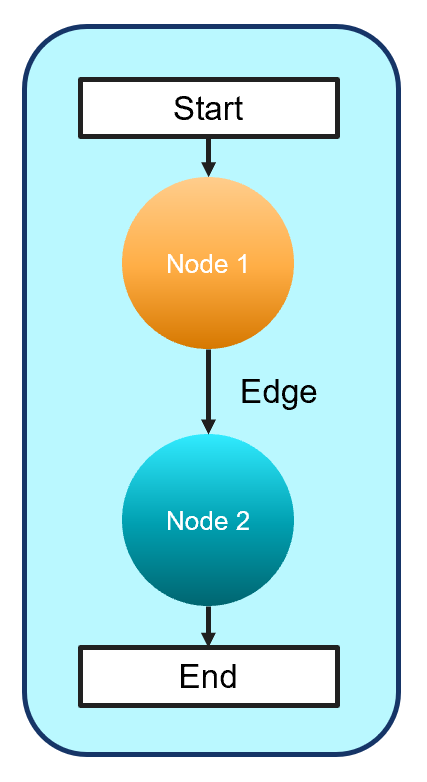

Step 1: Define two functions

In [ ]:
def func_1(input_1):
    return input_1 + " First Function"

def func_2(input_2):
    return input_2 + " to Second Function"

Step 2: Define Graph and add functions as Nodes

In [ ]:
from langgraph.graph import Graph

# Define a graph
workflow = Graph()

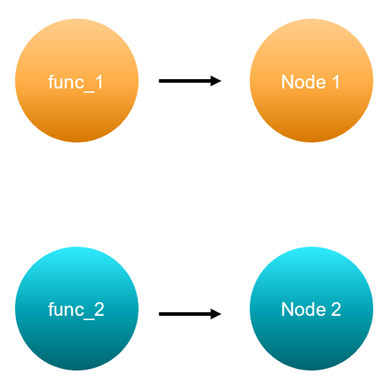

In [ ]:
# Add nodes to the graph
workflow.add_node("node_1",func_1)
workflow.add_node("node_2",func_2)

Step 3: Define a work flow and compile the Graph

In [ ]:
#Set Entry and Exit points
workflow.set_entry_point("node_1")

# Time to add edge
workflow.add_edge("node_1", "node_2")

workflow.set_finish_point("node_2")

graph = workflow.compile()

# **Now your Graph is Ready!!**

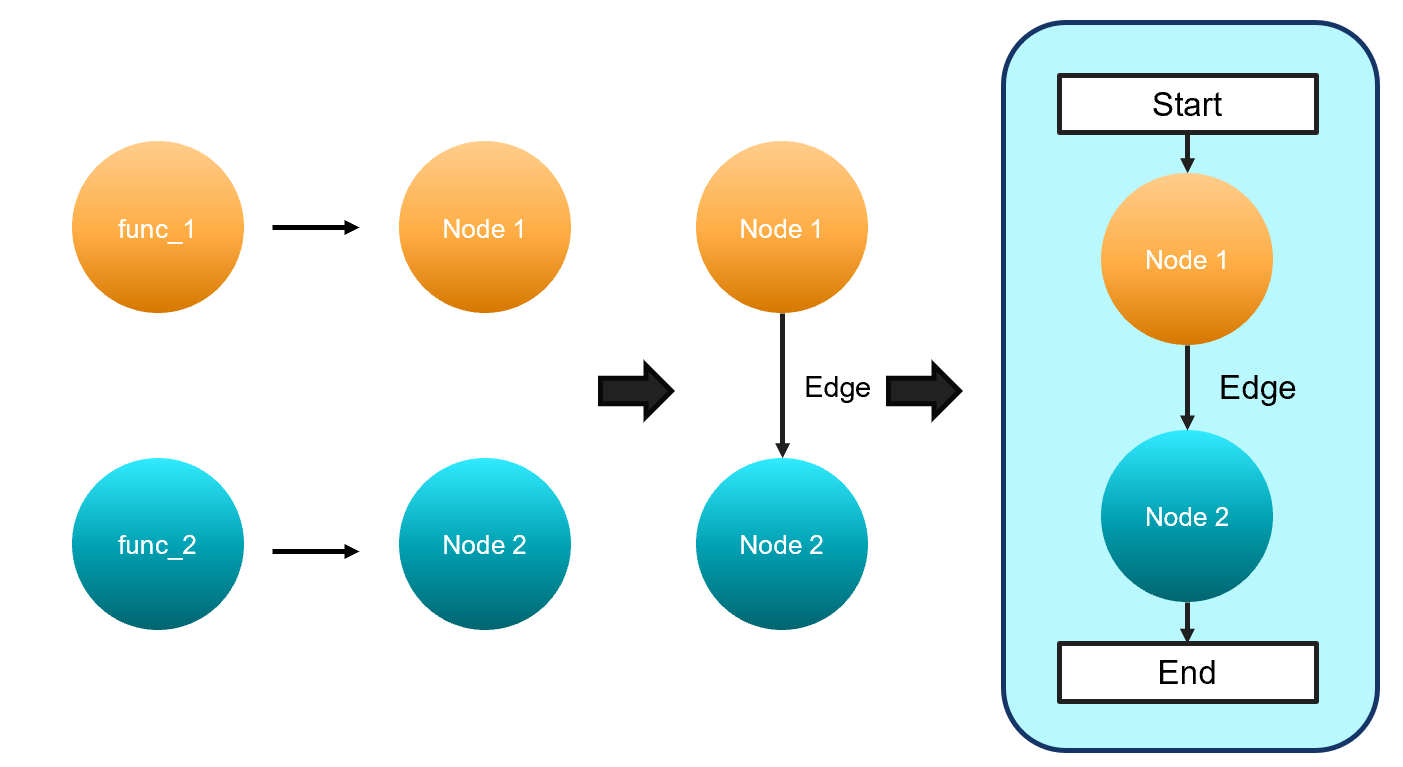

**Question**: Can I visualize the Graph I build?

**Answer**: YES!

Now Let's Visualize the Graph

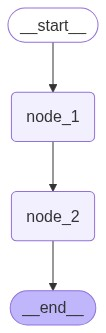

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Now Let's run the Graph

In [ ]:
graph.invoke("I move from")

'I move from First Function to Second Function'

**Question**: Can I experience the happenings in the Graph as it executes?

**Answer**: Yes, using the concept called **Streaming**

# **Streaming output from LangGraph**

stream() method outputs dictionary of the format

```
{node_name : output_from_the_node}
```



Lets travel through the Graph

In [ ]:
graph_input = 'I am moving from'
for output in graph.stream(graph_input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from '{key}':")
        print(value)

    print("---\n")

Output from 'node_1':
I am moving from First Function
---

Output from 'node_2':
I am moving from First Function to Second Function
---



Let's formalize a typical Graph building

# **Step-by-Step building of a Graph**

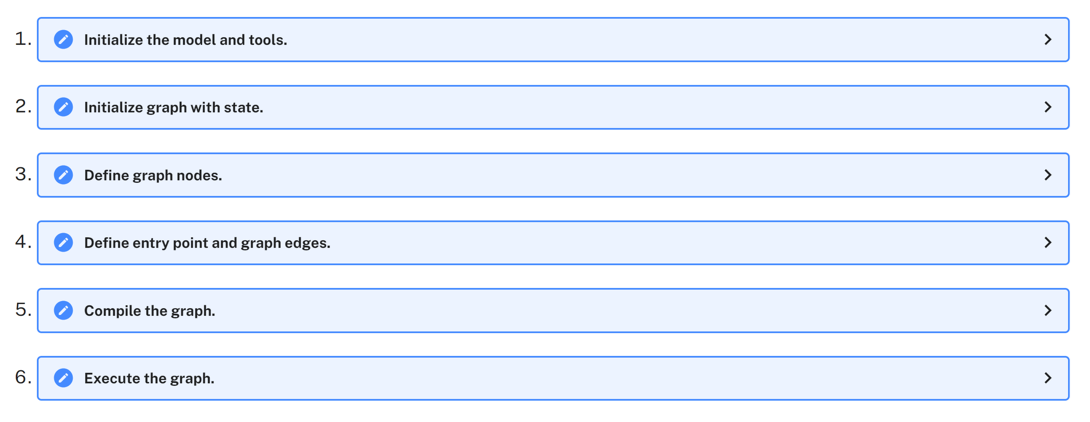

# **Now Let's build something Intersting using LangGraph**

## Sentiment Analysis using LangGraph

Define functions for Nodes

In [ ]:
def sentiment_analysis(input_1):
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {input_1}"""

    response = llm.invoke(SA_prompt)
    return response.content

def convert_to_upper(input_2):
    Sentiment_UPPER = input_2.upper()
    response = f"Here is the SENTIMENT in UPPER case: {Sentiment_UPPER}"
    return response

Construct the Graph Workflow

In [ ]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.set_entry_point("sentiment_analysis")

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visulize the Graph

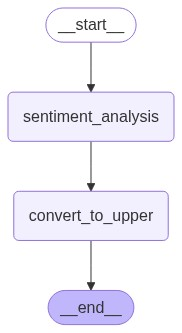

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

Now Let's run the Graph to identify the sentiments of Tweets

In [ ]:
tweet = "The movie was so nice that I walked out in 2 min"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: NEGATIVE'

In [ ]:
tweet = "Wish the movie was nice. But it was extraordinary"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: POSITIVE'

Let's experience the step by step happenings as the Graph executes

In [ ]:
for output in app.stream(tweet):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("---\n")

Output from node 'sentiment_analysis':
---
Positive
---

Output from node 'convert_to_upper':
---
Here is the SENTIMENT in UPPER case: POSITIVE
---



**Question**: This is Interesting! But I want to save the intermediate results of nodes in a centralized repository to access it all over the Graph. Is it possible?

**Answer**: Yes, this is possible using **State**

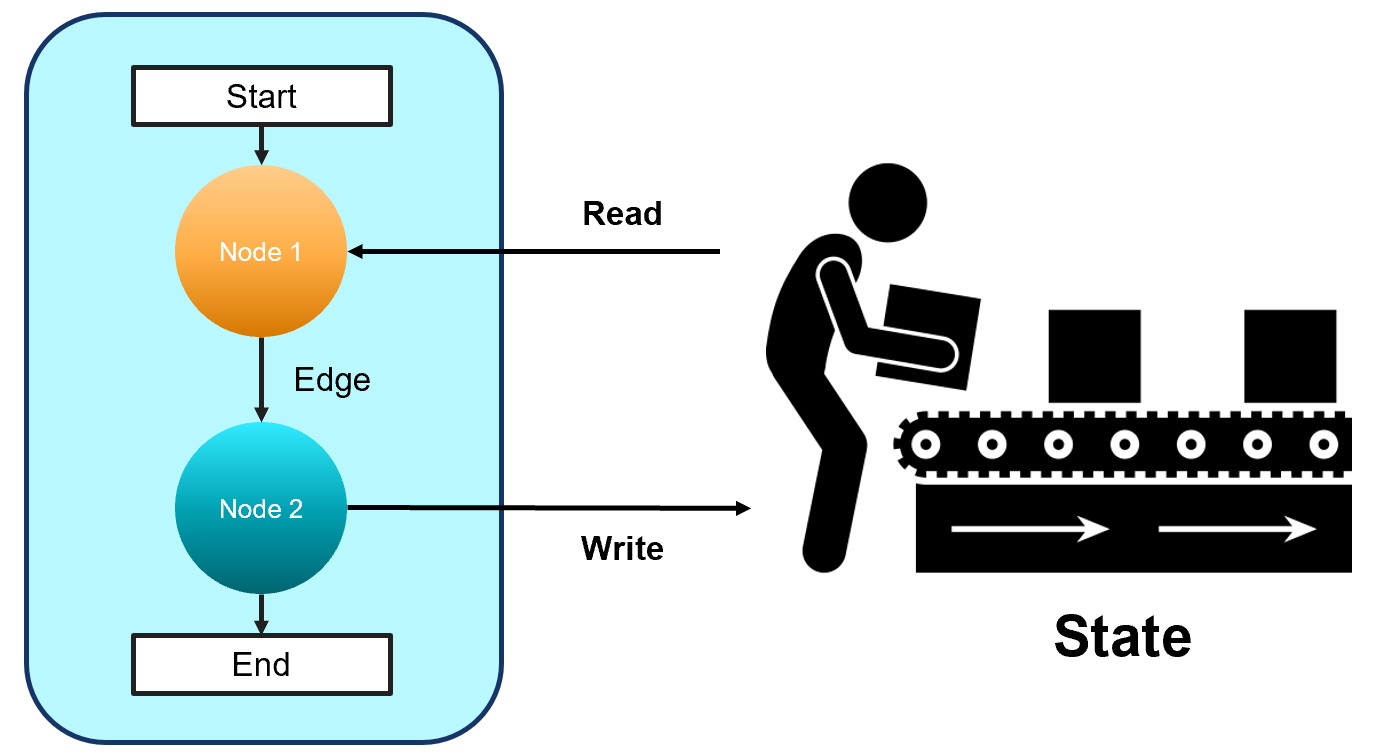

# **State**

One of the central concepts of LangGraph is state. Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes.


### Benefits

-Enables stateful applications that can maintain context over multiple interactions

-Allows for coordination between multiple agents or components

-Facilitates error handling and recovery via checkpointing

-Simplifies the development of complex workflows


Now let's introduce "state" to the above Graph.

**Define Graph State**

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    user_review: str
    sentiment_label: str
    sentiment_label_in_upper: str

State, in here is defined as a class containing a bunch of key value value pairs

In [ ]:
from IPython.display import Markdown

def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(f"State: {state}")
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    return {"sentiment_label": response.content}


def convert_to_upper(state):
    print("------ENTERING: CONVERT_TO_UPPER NODE------")
    display(Markdown("**State**"))
    print(f"State: {state}")
    Sentiment_UPPER = state['sentiment_label'].upper()
    return {"sentiment_label_in_upper": Sentiment_UPPER}

In [ ]:
# Define a graph
from langgraph.graph import StateGraph

workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.set_entry_point("sentiment_analysis")

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visualize the Graph

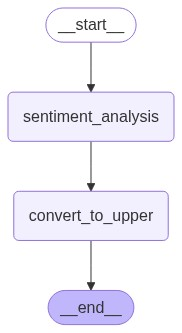

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

review = "The movie was so nice that I walked out in 2 min"
input_review = {"user_review": review}

# Run the graph until the first interruption
for output in app.stream(input_review, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'The movie was so nice that I walked out in 2 min'}
------ENTERING: SENTIMENT ANALYSIS NODE------
State: {'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative'}
------ENTERING: CONVERT_TO_UPPER NODE------


**State**

State: {'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': 'NEGATIVE'}


In [ ]:
from simple_colors import *

review = "Wish the movie was nice. But it was extraordinary"
input_review = {"user_review": review}

# Run the graph until the first interruption
for output in app.stream(input_review, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'Wish the movie was nice. But it was extraordinary'}
------ENTERING: SENTIMENT ANALYSIS NODE------
State: {'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive'}
------ENTERING: CONVERT_TO_UPPER NODE------


**State**

State: {'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': 'POSITIVE'}


**Question**: Wow! I am loving this already. But is there a way I can check a condition to decide if I will have to take a path A or B?

**Answer**: Yes, we can achieve this using **Conditional Edge**

## Conditional Edge

**Use Case**: Now I want my graph to further analyze the movie review and report what did not work for the user only if the sentiment is Negative/Mixed.

Let's Build the workflow for the above use case.

Define functions for Nodes

In [ ]:
import functools, operator
from typing import Annotated
from IPython.display import Markdown
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Notice that we have added "feedback_analysis" as an extra item
class State(TypedDict):
    user_review: str
    sentiment_label: str
    feedback_analysis: str
    overall_status: Annotated[str, operator.add]

def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(state)
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    print("--------")
    print(red(f"Sentiment Identified: [{response.content}]", ['bold']))
    print("--------")

    return {"sentiment_label": response.content}



def user_review_analysis(state):
    """
    Analyzes the user review and gives top reasons of what did not work for the user.
    """
    print("------ENTERING: USER REVIEW ANALYSIS NODE------")
    print(state)
    feedback_analysis_prompt = f"""You are an expert at performing analysis on the user review. The review can be about a movie or a product.
    Your task is to carefully analyze the user review and give top reasons of what did not work for the user.
    Make the answer readable.
    Note: Provide your analysis only using the user review and justify the sentiment

    User review: {state['user_review']}
    Sentiment Identified: {state['sentiment_label']}"""

    response = llm.invoke(feedback_analysis_prompt)

    display(Markdown(response.content))

    return {"feedback_analysis": response.content}

Define Graph and add Nodes

In [ ]:
# Define a graph
workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("user_review_analysis", user_review_analysis)

Define the workflow

In [ ]:
workflow.set_entry_point("sentiment_analysis")

def where_to_go(state):
    if state["sentiment_label"].lower() == "positive":
        return END
    else:
        return "user_review_analysis"

workflow.add_conditional_edges("sentiment_analysis", where_to_go, ["user_review_analysis", END])

workflow.add_edge('user_review_analysis', END)

app = workflow.compile()

Let's visualize the Graph

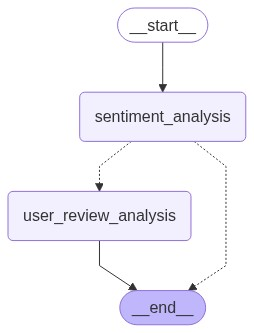

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

review = """The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    # print(cyan(output, ['bold']))
    pass

------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': None, 'feedback_analysis': None, 'overall_status': ''}
--------
Sentiment Identified: [Mixed]
--------
------ENTERING: USER REVIEW ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': 'Mixed', 'feedback_analysis': None, 'overall_status': ''}


**Analysis of What Did Not Work for the User:**

1. **Lack of Initial Engagement:**  
   The user mentions walking out of the hall after just one minute. This suggests that the movie failed to capture their interest or attention right from the beginning, indicating a weak or unappealing start.

2. **Inconsistent Experience:**  
   The user returned within five minutes but then slept through part of the movie. Sleeping during the film signals that the pacing or content was not compelling enough to keep them awake or interested.

3. **Ambiguous Enjoyment:**  
   The phrase "enjoyed with pain" implies that although there were enjoyable aspects, they were overshadowed by discomfort or disappointment. This mixed feeling points to flaws in the movie that detracted from overall enjoyment.

**Justification:**  
The user's behaviors—leaving the hall, sleeping during the film, and describing their enjoyment as painful—clearly indicate several aspects of the movie did not work for them, leading to a mixed sentiment.

In [ ]:
from simple_colors import *

review = """To be portrayed as the biggest Indian spectacle till date is a heavy accolade to hold, let alone achieve. And baahubali is definitely not up to the mark.

Let's look at the movie objectively:

1) Starting with the most talked about aspect of the movie VFX/CGI. The CGI is so over the top that it felt like a badly edited video game at times. For instance, the scene in which Baahubali is running away from the guards in the fort.

Loud and showy landscapes can not be termed as spectacular CGI. It should merge seamlessly with the movie and CGI stands out like a sore thumb in this one.

2)Acting: Its loud and crass to say the least. The reactions of all characters after every dialogue reminds a bit of the daily soaps.

3)StoryLine: Its old and repetitive from a 1000 other movies of the same genre. A messiah who comes to save the day. Yes, that's never been done before in Indian cinema.

However, despite all the above points Baahubali puts in a valiant effort. But to compare it to the likes of Lord of the Rings and Hobbit with the sheer depth of Tolkien's work is sacrilege. No where near that league.

Only recommended for the faithful.
"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    # print(cyan(output, ['bold']))
    pass

------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': "To be portrayed as the biggest Indian spectacle till date is a heavy accolade to hold, let alone achieve. And baahubali is definitely not up to the mark.\n\nLet's look at the movie objectively:\n\n1) Starting with the most talked about aspect of the movie VFX/CGI. The CGI is so over the top that it felt like a badly edited video game at times. For instance, the scene in which Baahubali is running away from the guards in the fort.\n\nLoud and showy landscapes can not be termed as spectacular CGI. It should merge seamlessly with the movie and CGI stands out like a sore thumb in this one.\n\n2)Acting: Its loud and crass to say the least. The reactions of all characters after every dialogue reminds a bit of the daily soaps.\n\n3)StoryLine: Its old and repetitive from a 1000 other movies of the same genre. A messiah who comes to save the day. Yes, that's never been done before in Indian cinema.\n\nHowever, despite all the above 

**Analysis: Top Reasons Why the Movie Did Not Work for the User**

1. **Poor Quality of VFX/CGI:**  
   The reviewer’s primary criticism is directed at the movie’s visual effects. They describe the CGI as “over the top,” comparing it to a “badly edited video game.” The user specifically mentions a scene where Baahubali escapes from the guards, highlighting how artificial and intrusive the effects felt. The reviewer expected seamless integration of CGI, but instead, it “stands out like a sore thumb,” detracting from the viewing experience.

2. **Unimpressive Acting:**  
   The acting was found to be “loud and crass.” The reviewer criticizes the exaggerated reactions of the characters, likening them to those seen in daily soap operas. This suggests that the performances lacked subtlety and depth, making the film feel melodramatic and less immersive.

3. **Clichéd Storyline:**  
   The storyline is described as “old and repetitive,” following the familiar trope of a messiah figure saving the day. The reviewer points out that this narrative has been done “a 1000 other movies of the same genre,” indicating a lack of originality or fresh perspective in the plot.

4. **Unfair Comparisons to International Epics:**  
   The reviewer feels that comparisons with legendary franchises like “Lord of the Rings” or “The Hobbit” are unfounded, stating that Baahubali does not achieve the same depth or quality. This further underscores their disappointment, especially given the high expectations set for the film.

**Justification of Sentiment:**  
The sentiment is clearly negative, as the reviewer systematically points out significant shortcomings in the film’s visual effects, acting, and story. While they acknowledge the effort behind Baahubali, the overall tone remains critical, concluding that the film is only for die-hard fans and is otherwise unworthy of the grand comparisons it has received.

**Question**: This is really Cool! Now I want to run multiple nodes parallelly. Is that possible?

**Answer**: Yes, this can be achieved using **Branching** Concept

# **Branching**

Let's understand how can we run parallel nodes using Branching Concept

In [ ]:
import time
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph

class State(TypedDict):
    # The operator.add reducer function adds the value
    sequential_execution_time: Annotated[int, operator.add]


def start_node(state):
    print("------ENTERING: START NODE------")
    return {"sequential_execution_time": 0}

def parallel_node_A(state):
    print("------ENTERING: NODE A------")
    time.sleep(5)
    return {"sequential_execution_time": 5}

def parallel_node_B(state):
    print("------ENTERING: NODE B------")
    time.sleep(5)
    return {"sequential_execution_time": 5}

def parallel_node_C(state):
    print("------ENTERING: NODE C------")
    time.sleep(5)
    return {"sequential_execution_time": 5}

def end_node(state):
    print("------ENTERING: END NODE------")
    return {"sequential_execution_time": 0}

workflow = StateGraph(State)

workflow.add_node("start_node", start_node)
workflow.add_node("parallel_node_A", parallel_node_A)
workflow.add_node("parallel_node_B", parallel_node_B)
workflow.add_node("parallel_node_C", parallel_node_C)
workflow.add_node("end_node", end_node)


workflow.set_entry_point("start_node")

workflow.add_edge('start_node', 'parallel_node_A')
workflow.add_edge('start_node', 'parallel_node_B')
workflow.add_edge('start_node', 'parallel_node_C')

workflow.add_edge('parallel_node_A', 'end_node')
workflow.add_edge('parallel_node_B', 'end_node')
workflow.add_edge('parallel_node_C', 'end_node')

workflow.set_finish_point("end_node")

graph = workflow.compile()

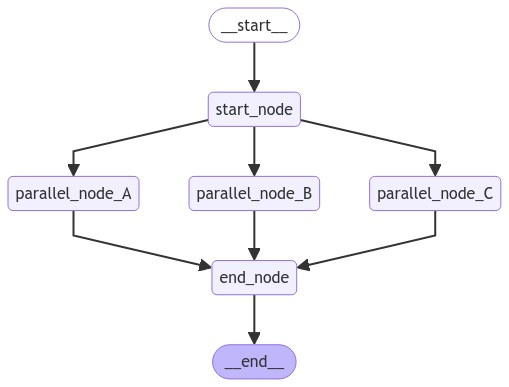

In [ ]:

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's see the power of Branching now

In [ ]:
inputs = {}
start_time = time.time()

for output in graph.stream(inputs, stream_mode="values"):
    print(cyan(output, ['bold']))
    pass

ex_time = time.time() - start_time

print("--------------------------------------------------------")
print(red(f"Original Time Taken - [{round(ex_time, 2)}]", ['bold']))
print("--------------------------------------------------------")

------ENTERING: START NODE------
{'sequential_execution_time': 0}
------ENTERING: NODE A------
------ENTERING: NODE B------
------ENTERING: NODE C------
{'sequential_execution_time': 15}
------ENTERING: END NODE------
{'sequential_execution_time': 15}
--------------------------------------------------------
Original Time Taken - [5.07]
--------------------------------------------------------
